<img src="https://certificate.tpq.io/taim_logo.png" width="350px" align="right">

# Artificial Intelligence in Finance

## Dense Neural Networks

Dr Yves J Hilpisch | The AI Machine

http://aimachine.io | http://twitter.com/dyjh

In [1]:
import os
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'

In [3]:
symbol = 'EUR_USD'

In [4]:
raw = pd.read_csv(url, index_col=0, parse_dates=True)

In [5]:
raw.head()

,HIGH,LOW,OPEN,CLOSE
Date,,,,
2019-10-01 00:00:00,1.0899,1.0897,1.0897,1.0899
2019-10-01 00:01:00,1.0899,1.0896,1.0899,1.0898
2019-10-01 00:02:00,1.0898,1.0896,1.0898,1.0896
2019-10-01 00:03:00,1.0898,1.0896,1.0897,1.0898
2019-10-01 00:04:00,1.0898,1.0896,1.0897,1.0898


In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96526 entries, 2019-10-01 00:00:00 to 2019-12-31 23:06:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HIGH    96526 non-null  float64
 1   LOW     96526 non-null  float64
 2   OPEN    96526 non-null  float64
 3   CLOSE   96526 non-null  float64
dtypes: float64(4)
memory usage: 3.7 MB


In [7]:
data = pd.DataFrame(raw['CLOSE'].loc[:])
data.columns = [symbol]

In [8]:
data = data.resample('1h', label='right').last().ffill()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2019-10-01 01:00:00 to 2020-01-01 00:00:00
Freq: H
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EUR_USD  2208 non-null   float64
dtypes: float64(1)
memory usage: 34.5 KB


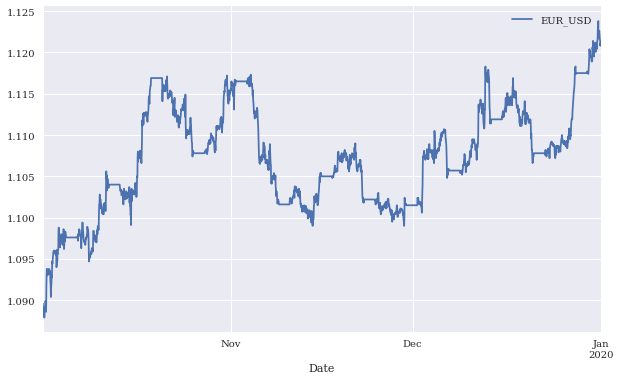

In [10]:
data.plot(figsize=(10, 6));
# plt.savefig('../../images/ch07/figure_dnn_01.png')

In [11]:
lags = 5

In [12]:
def add_lags(data, symbol, lags, window=20):
    cols = []
    df = data.copy()
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    df['sma'] = df[symbol].rolling(window).mean()
    df['min'] = df[symbol].rolling(window).min()
    df['max'] = df[symbol].rolling(window).max()
    df['mom'] = df['r'].rolling(window).mean()
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    df['d'] = np.where(df['r'] > 0, 1, 0)
    features = [symbol, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']
    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [13]:
data, cols = add_lags(data, symbol, lags)

In [14]:
len(data)

2183

In [15]:
c = data['d'].value_counts()
c

0    1445
1     738
Name: d, dtype: int64

In [16]:
def cw(df):
    c0, c1 = np.bincount(df['d'])
    w0 = (1 / c0) * (len(df)) / 2
    w1 = (1 / c1) * (len(df)) / 2
    return {0: w0, 1: w1}

In [17]:
class_weight = cw(data)

In [18]:
class_weight

{0: 0.755363321799308, 1: 1.4789972899728998}

In [19]:
class_weight[0] * c[0]

1091.5

In [20]:
class_weight[1] * c[1]

1091.5

In [21]:
import random
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [22]:
def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [23]:
optimizer = Adam(lr=0.001)

In [24]:
def create_model(hl=1, hu=128, optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [25]:
set_seeds()
model = create_model(hl=1, hu=128)

In [26]:
%%time
model.fit(data[cols], data['d'], epochs=50,
          verbose=False, class_weight=cw(data))

CPU times: user 6.44 s, sys: 939 ms, total: 7.38 s
Wall time: 4.07 s


In [27]:
model.evaluate(data[cols], data['d'])

2183/2183 [==============================] - 0s 24us/step


[0.582192026280068, 0.6087952256202698]

In [28]:
data['p'] = np.where(model.predict(data[cols]) > 0.5, 1, 0)

In [29]:
data['p'].value_counts()

1    1340
0     843
Name: p, dtype: int64

In [30]:
split = int(len(data) * 0.8)

In [31]:
train = data.iloc[:split].copy()

In [32]:
test = data.iloc[split:].copy()

In [33]:
set_seeds()
model = create_model(hl=1, hu=128)

In [34]:
%%time 
model.fit(train[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 4.72 s, sys: 686 ms, total: 5.41 s
Wall time: 3.14 s


In [35]:
model.evaluate(train[cols], train['d'])

1746/1746 [==============================] - 0s 13us/step


[0.612861613500842, 0.5853379368782043]

In [36]:
model.evaluate(test[cols], test['d'])

437/437 [==============================] - 0s 16us/step


[0.5946959675858714, 0.6247139573097229]

In [37]:
test['p'] = np.where(model.predict(test[cols]) > 0.5, 1, 0)

In [38]:
test['p'].value_counts()

1    291
0    146
Name: p, dtype: int64

In [39]:
res = pd.DataFrame(model.history.history)

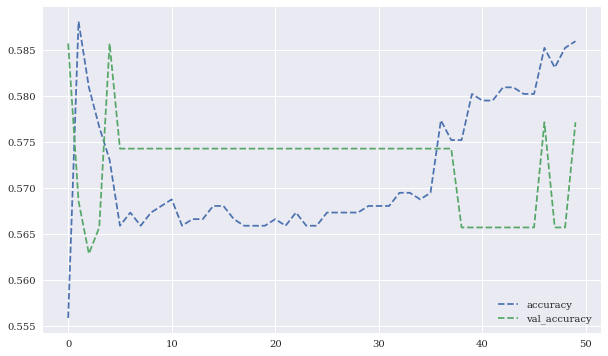

In [40]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');
# plt.savefig('../../images/ch07/figure_dnn_02.png')

In [41]:
mu, std = train.mean(), train.std()

In [42]:
train_ = (train - mu) / std

In [43]:
set_seeds()
model = create_model(hl=2, hu=128)

In [44]:
%%time 
model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 5.81 s, sys: 879 ms, total: 6.69 s
Wall time: 3.53 s


In [45]:
model.evaluate(train_[cols], train['d'])

1746/1746 [==============================] - 0s 14us/step


[0.4253406366728084, 0.887170672416687]

In [46]:
test_ = (test - mu) / std

In [47]:
model.evaluate(test_[cols], test['d'])

437/437 [==============================] - 0s 24us/step


[1.1377735263422917, 0.681922197341919]

In [48]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

In [49]:
test['p'].value_counts()

0    281
1    156
Name: p, dtype: int64

In [50]:
res = pd.DataFrame(model.history.history)

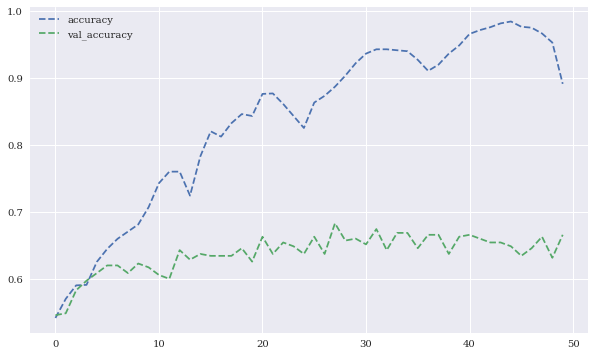

In [51]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');
# plt.savefig('../../images/ch07/figure_dnn_03.png')

In [52]:
from keras.layers import Dropout

In [53]:
def create_model(hl=1, hu=128, dropout=True, rate=0.3,
                 optimizer=optimizer):
    model = Sequential()
    model.add(Dense(hu, input_dim=len(cols),
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu'))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [54]:
set_seeds()
model = create_model(hl=1, hu=128, rate=0.3)

In [55]:
%%time 
model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.15, shuffle=False,
          class_weight=cw(train))

CPU times: user 5.46 s, sys: 758 ms, total: 6.21 s
Wall time: 3.53 s


In [56]:
model.evaluate(train_[cols], train['d'])

1746/1746 [==============================] - 0s 20us/step


[0.4423361133190911, 0.7840778827667236]

In [57]:
model.evaluate(test_[cols], test['d'])

437/437 [==============================] - 0s 34us/step


[0.5875822428434883, 0.6430205702781677]

In [58]:
res = pd.DataFrame(model.history.history)

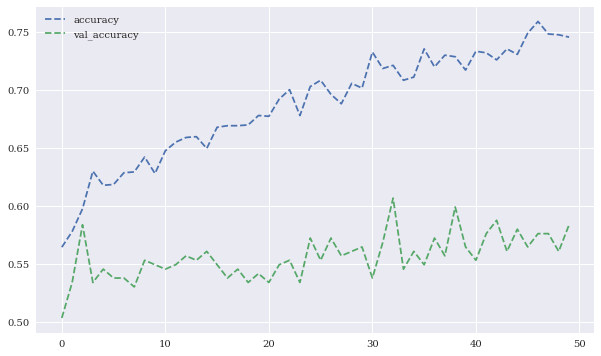

In [59]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');
# plt.savefig('../../images/ch07/figure_dnn_04.png')

In [60]:
from keras.regularizers import l1, l2

In [61]:
def create_model(hl=1, hu=128, dropout=False, rate=0.3, 
                 regularize=False, reg=l1(0.0005),
                 optimizer=optimizer, input_dim=len(cols)):
    if not regularize:
        reg = None
    model = Sequential()
    model.add(Dense(hu, input_dim=input_dim,
                    activity_regularizer=reg,
                    activation='relu'))
    if dropout:
        model.add(Dropout(rate, seed=100))
    for _ in range(hl):
        model.add(Dense(hu, activation='relu',
                        activity_regularizer=reg))
        if dropout:
            model.add(Dropout(rate, seed=100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer,
                 metrics=['accuracy'])
    return model

In [62]:
set_seeds()
model = create_model(hl=1, hu=128, regularize=True)

In [63]:
%%time 
model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 5.49 s, sys: 1.05 s, total: 6.54 s
Wall time: 3.15 s


In [64]:
model.evaluate(train_[cols], train['d'])

1746/1746 [==============================] - 0s 15us/step


[0.5307255412568205, 0.7691867351531982]

In [65]:
model.evaluate(test_[cols], test['d'])

437/437 [==============================] - 0s 22us/step


[0.8428352184644826, 0.6590389013290405]

In [66]:
res = pd.DataFrame(model.history.history)

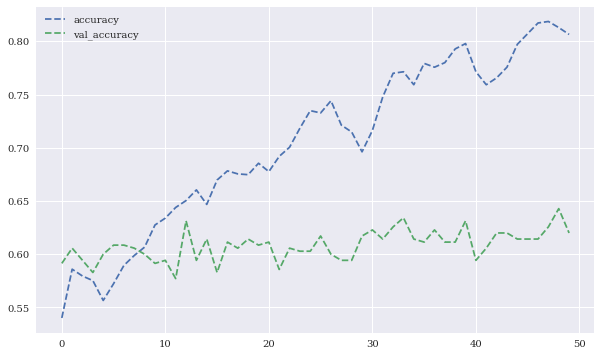

In [67]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');
# plt.savefig('../../images/ch07/figure_dnn_05.png')

In [68]:
set_seeds()
model = create_model(hl=2, hu=128,
                     dropout=True, rate=0.3,
                     regularize=True, reg=l2(0.001),
                    )

In [69]:
%%time 
model.fit(train_[cols], train['d'],
          epochs=50, verbose=False,
          validation_split=0.2, shuffle=False,
          class_weight=cw(train))

CPU times: user 7.06 s, sys: 958 ms, total: 8.01 s
Wall time: 4.28 s


In [70]:
model.evaluate(train_[cols], train['d'])

1746/1746 [==============================] - 0s 18us/step


[0.5007762827004764, 0.7691867351531982]

In [71]:
model.evaluate(test_[cols], test['d'])

437/437 [==============================] - 0s 23us/step


[0.6191965124699835, 0.6864988803863525]

In [72]:
res = pd.DataFrame(model.history.history)

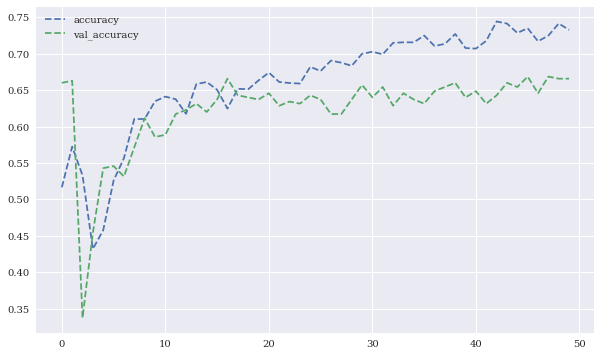

In [73]:
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');
# plt.savefig('../../images/ch07/figure_dnn_06.png')

In [74]:
res.mean()['accuracy'] - res.mean()['val_accuracy']

0.03912009656429294

In [75]:
from sklearn.ensemble import BaggingClassifier
from keras.wrappers.scikit_learn import KerasClassifier

In [76]:
max_features = 0.75

In [77]:
set_seeds()
base_estimator = KerasClassifier(build_fn=create_model,
                        verbose=False, epochs=20, hl=1, hu=128,
                        dropout=True, regularize=False,
                        input_dim=int(len(cols) * max_features))

In [78]:
model_bag = BaggingClassifier(base_estimator=base_estimator,
                          n_estimators=15,
                          max_samples=0.75,
                          max_features=max_features,
                          bootstrap=True,
                          bootstrap_features=True,
                          n_jobs=1,
                          random_state=100,
                         )

In [79]:
%time model_bag.fit(train_[cols], train['d'])

CPU times: user 40 s, sys: 5.23 s, total: 45.3 s
Wall time: 26.3 s


BaggingClassifier(base_estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fbfa7cc7b90>,
                  bootstrap_features=True, max_features=0.75, max_samples=0.75,
                  n_estimators=15, n_jobs=1, random_state=100)

In [80]:
model_bag.score(train_[cols], train['d'])

0.720504009163803

In [81]:
model_bag.score(test_[cols], test['d'])

0.6704805491990846

In [82]:
test['p'] = model_bag.predict(test_[cols])

In [83]:
test['p'].value_counts()

0    408
1     29
Name: p, dtype: int64

In [84]:
import time

In [85]:
optimizers = ['sgd', 'rmsprop', 'adagrad', 'adadelta',
              'adam', 'adamax', 'nadam']

In [86]:
%%time
for optimizer in optimizers:
    set_seeds()
    model = create_model(hl=1, hu=128,
                     dropout=True, rate=0.3,
                     regularize=False, reg=l2(0.001),
                     optimizer=optimizer
                    )
    t0 = time.time()
    model.fit(train_[cols], train['d'],
              epochs=50, verbose=False,
              validation_split=0.2, shuffle=False,
              class_weight=cw(train))
    t1 = time.time()
    t = t1 - t0
    acc_tr = model.evaluate(train_[cols], train['d'], verbose=False)[1]
    acc_te = model.evaluate(test_[cols], test['d'], verbose=False)[1]
    out = f'{optimizer:10s} | time[s]: {t:.4f} | in-sample={acc_tr:.4f}'
    out += f' | out-of-sample={acc_te:.4f}'
    print(out)

sgd        | time[s]: 2.8092 | in-sample=0.6363 | out-of-sample=0.6568
rmsprop    | time[s]: 2.9480 | in-sample=0.7600 | out-of-sample=0.6613
adagrad    | time[s]: 2.8472 | in-sample=0.6747 | out-of-sample=0.6499
adadelta   | time[s]: 3.2068 | in-sample=0.7279 | out-of-sample=0.6522
adam       | time[s]: 3.2364 | in-sample=0.7365 | out-of-sample=0.6545
adamax     | time[s]: 3.2465 | in-sample=0.6982 | out-of-sample=0.6476
nadam      | time[s]: 4.1275 | in-sample=0.7944 | out-of-sample=0.6590
CPU times: user 35.9 s, sys: 4.55 s, total: 40.4 s
Wall time: 23.1 s


In [87]:
test['p'] = np.where(model.predict(test_[cols]) > 0.5, 1, 0)

In [88]:
test['p'].value_counts()

0    303
1    134
Name: p, dtype: int64

In [89]:
accuracy_score(model.predict_classes(test_[cols]), test['d'])

0.6590389016018307

In [90]:
test = test.copy()

In [91]:
# test['p'] = np.where(model_bag.predict(test_[cols]) == 1, 1, -1)
test['p'] = np.where(model.predict_classes(test_[cols]) == 1, 1, -1)

In [92]:
test['p'].value_counts()

-1    303
 1    134
Name: p, dtype: int64

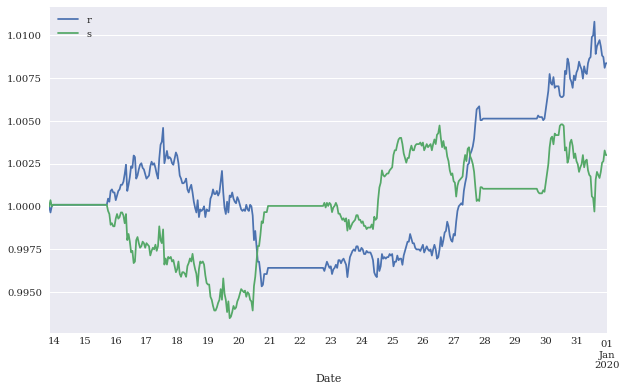

In [93]:
test['s'] = test['p'] * test['r']
test[['r', 's']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [94]:
test['p'].value_counts()

-1    303
 1    134
Name: p, dtype: int64

<img src='http://hilpisch.com/taim_logo.png' width="350px" align="right">

<br><br><br><a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:ai@tpq.io">ai@tpq.io</a>